In [12]:
%load_ext autoreload
%autoreload 2

In [61]:
import json
example_dir_path = '../proteinmpnn-input-examples'

parsed_pdbs_path = f'{example_dir_path}/parsed_pdbs.jsonl'
fixed_pdbs_path = f'{example_dir_path}/fixed_pdbs.jsonl'
tied_pdbs_path = f'{example_dir_path}/tied_pdbs.jsonl'

with open(parsed_pdbs_path) as fp:
    parsed_pdbs = json.load(fp)

with open(fixed_pdbs_path) as fp:
    fixed_pdbs = json.load(fp)

with open(tied_pdbs_path) as fp:
    tied_pdbs = json.load(fp)

In [62]:
len(parsed_pdbs['seq']), len(parsed_pdbs['seq_chain_A']), len(parsed_pdbs['seq_chain_B']), len(parsed_pdbs['seq_chain_C']), len(parsed_pdbs['seq_chain_D'])

(300, 75, 75, 75, 75)

In [66]:
parsed_pdbs['name']

'D5_0'

In [15]:
batch = [parsed_pdbs]
print('batch len', len(batch))

tied_positions_dict = tied_pdbs

ca_only = False

# this would not be null if user provides args.chain_id_jsonl
chain_dict = None

batch len 1


In [16]:
tied_positions_dict

{'D5_0': [{'A': [1], 'C': [1]},
  {'A': [2], 'C': [2]},
  {'A': [3], 'C': [3]},
  {'A': [4], 'C': [4]},
  {'A': [5], 'C': [5]},
  {'A': [6], 'C': [6]},
  {'A': [7], 'C': [7]},
  {'A': [8], 'C': [8]},
  {'A': [9], 'C': [9]},
  {'A': [10], 'C': [10]},
  {'A': [11], 'C': [11]},
  {'A': [12], 'C': [12]},
  {'A': [13], 'C': [13]},
  {'A': [14], 'C': [14]},
  {'A': [15], 'C': [15]},
  {'A': [16], 'C': [16]},
  {'A': [17], 'C': [17]},
  {'A': [18], 'C': [18]},
  {'A': [19], 'C': [19]},
  {'A': [20], 'C': [20]},
  {'A': [21], 'C': [21]},
  {'A': [22], 'C': [22]},
  {'A': [23], 'C': [23]},
  {'A': [24], 'C': [24]},
  {'A': [25], 'C': [25]},
  {'A': [26], 'C': [26]},
  {'A': [27], 'C': [27]},
  {'A': [28], 'C': [28]},
  {'A': [29], 'C': [29]},
  {'A': [30], 'C': [30]},
  {'A': [31], 'C': [31]},
  {'A': [32], 'C': [32]},
  {'A': [33], 'C': [33]},
  {'A': [34], 'C': [34]},
  {'A': [35], 'C': [35]},
  {'A': [36], 'C': [36]},
  {'A': [37], 'C': [37]},
  {'A': [38], 'C': [38]},
  {'A': [39], 'C': [39

In [17]:
batch[0].keys()

dict_keys(['name', 'num_of_chains', 'seq', 'seq_chain_A', 'coords_chain_A', 'seq_chain_B', 'coords_chain_B', 'seq_chain_C', 'coords_chain_C', 'seq_chain_D', 'coords_chain_D'])

In [18]:
import numpy as np

alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
B = len(batch)
lengths = np.array([len(b['seq']) for b in batch], dtype=np.int32) #sum of chain seq lengths
L_max = max([len(b['seq']) for b in batch])
if ca_only:
    X = np.zeros([B, L_max, 1, 3])
else:
    X = np.zeros([B, L_max, 4, 3])
residue_idx = -100*np.ones([B, L_max], dtype=np.int32)

chain_M = np.zeros([B, L_max], dtype=np.int32) #1.0 for the bits that need to be predicted
chain_M_pos = np.zeros([B, L_max], dtype=np.int32) #1.0 for the bits that need to be predicted

pssm_coef_all = np.zeros([B, L_max], dtype=np.float32) #1.0 for the bits that need to be predicted
pssm_bias_all = np.zeros([B, L_max, 21], dtype=np.float32) #1.0 for the bits that need to be predicted

# WHATS 21 here!?
# num_letters=21 this is passed to initialize ProteinMPNNModel
# seems to control the number of outputs on the last linear layer of network
pssm_log_odds_all = 10000.0*np.ones([B, L_max, 21], dtype=np.float32) #1.0 for the bits that need to be predicted

bias_by_res_all = np.zeros([B, L_max, 21], dtype=np.float32)
chain_encoding_all = np.zeros([B, L_max], dtype=np.int32) #1.0 for the bits that need to be predicted
S = np.zeros([B, L_max], dtype=np.int32)
omit_AA_mask = np.zeros([B, L_max, len(alphabet)], dtype=np.int32)
# Build the batch
letter_list_list = []
visible_list_list = []
masked_list_list = []
masked_chain_length_list_list = []
tied_pos_list_of_lists_list = []


In [19]:
X.shape, residue_idx.shape, lengths     # batch size, L_max (maximum sequence length on one chain), 4 (# atoms i assume), 3 (xyz coords)

((1, 300, 4, 3), (1, 300), array([300], dtype=int32))

In [20]:
for i, b in enumerate(batch):
    if chain_dict != None:
        masked_chains, visible_chains = chain_dict[b['name']] #masked_chains a list of chain letters to predict [A, D, F]
    else:
        masked_chains = [item[-1:] for item in list(b) if item[:10]=='seq_chain_']
        visible_chains = []
    masked_chains.sort() #sort masked_chains
    visible_chains.sort() #sort visible_chains
    all_chains = masked_chains + visible_chains

In [21]:
masked_chains, visible_chains, all_chains

(['A', 'B', 'C', 'D'], [], ['A', 'B', 'C', 'D'])

LETS STEP THROUGH tied_featurize function to see what the heck is happening here

PSEUDO CODE!

tied_featurize:
    inputs: 
        batch - List[parsed_pdbs]
        device - cpu/cuda, 
        chain_dict - , 
        fixed_position_dict=None, 
        omit_AA_dict=None, 
        tied_positions_dict=None, 
        pssm_dict=None, 
        bias_by_res_dict=None, 
        ca_only=False

    outputs:
        X_out, 
        S, 
        mask, 
        lengths, 
        chain_M, 
        chain_encoding_all, 
        letter_list_list, 
        visible_list_list, 
        masked_list_list, 
        masked_chain_length_list_list, 
        chain_M_pos, 
        omit_AA_mask, 
        residue_idx, 
        dihedral_mask, 
        tied_pos_list_of_lists_list, 
        pssm_coef_all, 
        pssm_bias_all, 
        pssm_log_odds_all, 
        bias_by_res_all, 
        tied_beta

    ALGORITHM

        1.  initialize some things
        2.  for each batch
        2.1     create all_chains from masked and visible chains
        3.  for each batch

        3.2        for step, letter in enumerate(all_chains):
        3.3             if chain is a visible_chains
        
        3.4             if chain is a masked_chain
                




In [ ]:

def


In [9]:
STEP, LETTER
list(enumerate(all_chains))

NameError: name 'STEP' is not defined

In [10]:
# enumerate batches for loop - FIRST ITERATION HERE!!!
i, b = list(enumerate(batch))[0]
print(i,b)

mask_dict = {}
a = 0
x_chain_list = []
chain_mask_list = []
chain_seq_list = []
chain_encoding_list = []
c = 1
letter_list = []
global_idx_start_list = [0]
visible_list = []
masked_list = []
masked_chain_length_list = []
fixed_position_mask_list = []
omit_AA_mask_list = []
pssm_coef_list = []
pssm_bias_list = []
pssm_log_odds_list = []
bias_by_res_list = []
l0 = 0
l1 = 0

0 {'name': 'D5_0', 'num_of_chains': 4, 'seq': 'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG', 'seq_chain_A': 'GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG', 'coords_chain_A': {'N_chain_A': [[-15.704, 5.706, 18.924], [-12.964, 5.695, 18.751], [-12.562, 5.057, 16.071], [-13.528, 7.436, 14.965], [-11.56, 9.237, 15.85], [-9.342, 8.212, 14.493], [-10.167, 8.744, 11.892], [-10.252, 11.553, 11.874], [-7.546, 12.144, 12.271], [-6.498, 11.105, 9.922], [-7.692, 12.722, 8.006], [-6.548, 15.182, 8.569], [-3.903, 14.636, 7.939], [-4.05, 14.185, 5.19], [-4.881, 16.639, 4.313], [-2.695, 18.186, 4.925], [-1.008, 17.376, 3.026], [-2.196, 17.9, 0.764], [-3.95, 16.315, -0.59], [-6.9, 14.792, -1.858], [-9.767, 13.438, -0.22

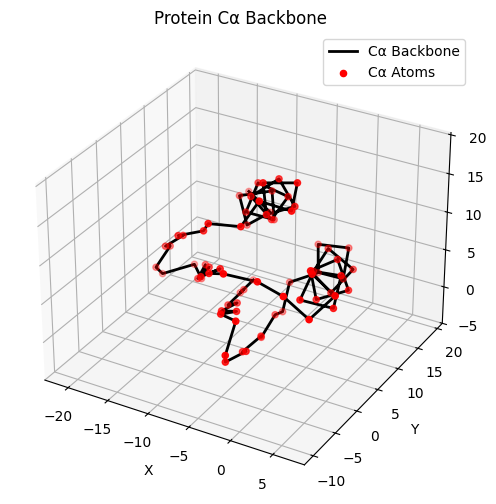

In [11]:
points = np.array(b['coords_chain_A']['CA_chain_A'])

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example Cα coordinates (replace this with your actual data)
ca_coords = points

# Extract x, z, y coordinates (since your order is xzy)
x = ca_coords[:, 0]
z = ca_coords[:, 1]
y = ca_coords[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the backbone as a line
ax.plot(x, y, z, color='black', linewidth=2, label='Cα Backbone')

# Scatter plot Cα atoms
ax.scatter(x, y, z, c='r', marker='o', s=20, label='Cα Atoms')

# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Protein Cα Backbone')

# Show plot
plt.legend()
plt.show()


In [13]:
!pip install py3Dmol

  Using cached py3Dmol-2.4.2-py2.py3-none-any.whl.metadata (1.9 kB)
Using cached py3Dmol-2.4.2-py2.py3-none-any.whl (7.0 kB)

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [41]:
import py3Dmol

def get_pdb_from_atom_positions(points):
    """
    Converts a NumPy array of atomic positions into a PDB-formatted string.

    Args:
        points (np.ndarray): A (N, 4, 3) array where:
            - N = Number of residues
            - 4 = Atoms per residue (N, CA, C, O)
            - 3 = Cartesian coordinates (x, z, y)

        TODO: MAKE THIS ALSO SUPPORT 1 atom per residue - Ca atom only

    Returns:
        str: PDB-formatted string.
    """
    atom_names = ["N", "CA", "C", "O"]  # Atoms in a glycine residue
    pdb_str = ""
    atom_index = 1  # Atom serial number

    for res_id, residue in enumerate(points, start=1):  # Iterate over residues
        for atom_id, (x, z, y) in enumerate(residue):  # Iterate over atoms, preserving (x, z, y) order
            pdb_str += (
                f"HETATM{atom_index:5d}  {atom_names[atom_id]:<2}  GLY A{res_id:4d}    "
                f"{x:8.3f}{y:8.3f}{z:8.3f}  1.00 20.00           C  \n"
            )
            atom_index += 1  # Increment global atom index

    return pdb_str



def view_atom_position_tensor(X, residue_colors = None):
    """Given a (aa len, # atoms, xyz coords) tensor, use py3Dmol to display

    Input:
        X: (aa len, num atoms per aa, xyz)
        residue_colors: Dict[residue pos, color string]

    Example:
        residue_colors = {
            1: "red",
            10: "blue",
            20: "green",
            30: "purple",
            40: "orange",
            50: "pink"
        }


    """
    pdb_str = get_pdb_from_atom_positions(points)

    # Create 3Dmol viewer
    view = py3Dmol.view(width=500, height=500)
    view.addModel(pdb_str, "pdb")

    # Define colors for specific residue numbers


    # Default color for all other residues
    view.setStyle({"cartoon": {"color": "white"}})

    if residue_colors:
        # Apply different colors to specific residues
        for res_id, color in residue_colors.items():
            view.setStyle({"resi": str(res_id)}, {"cartoon": {"color": color}})


    #view.setStyle({"cartoon": {"color": "spectrum"}})
    view.zoomTo()
    view.show()


In [42]:
import py3Dmol

chain_coords = b['coords_chain_A']
letter = 'A'
points = np.stack([
        chain_coords[c]
        for c in [
            f'N_chain_{letter}', f'CA_chain_{letter}', f'C_chain_{letter}', f'O_chain_{letter}'
        ]
    ], 1)

residue_colors = {
    1: "red",
    10: "blue",
    20: "green",
    30: "purple",
    40: "orange",
    50: "pink"
}

print(points.shape)
view_atom_position_tensor(points, residue_colors)


(75, 4, 3)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [61]:
step, letter = list(enumerate(all_chains))[0]
print(step, letter)

0 A


In [63]:
letter in masked_chains

True

In [31]:
#  if letter in masked_chains: WHICH IS TRUE
masked_list.append(letter)
letter_list.append(letter)
chain_seq = b[f'seq_chain_{letter}']
chain_seq = ''.join([a if a!='-' else 'X' for a in chain_seq])

print(letter_list)
print(chain_seq)

chain_length = len(chain_seq)
global_idx_start_list.append(global_idx_start_list[-1]+chain_length)
masked_chain_length_list.append(chain_length)
chain_coords = b[f'coords_chain_{letter}'] #this is a dictionary
chain_mask = np.ones(chain_length) #1.0 for masked

print('ca_only', ca_only)
if ca_only:
    x_chain = np.array(chain_coords[f'CA_chain_{letter}']) #[chain_lenght,1,3] #CA_diff
    if len(x_chain.shape) == 2:
        x_chain = x_chain[:,None,:]
else:
    x_chain = np.stack([
        chain_coords[c]
        for c in [
            f'N_chain_{letter}', f'CA_chain_{letter}', f'C_chain_{letter}', f'O_chain_{letter}'
        ]
    ], 1) #[chain_lenght,4,3]

print('chain len', chain_length)
print('global_idx_start_list', global_idx_start_list)
print(masked_chain_length_list)
print('chain_coords', chain_coords.keys())
print('chain_mask', chain_mask.shape)
print('x_chain', x_chain.shape)

x_chain_list.append(x_chain)
chain_mask_list.append(chain_mask)
chain_seq_list.append(chain_seq)

chain_encoding_list.append(c*np.ones(np.array(chain_mask).shape[0]))

print('chain_encoding_list', chain_encoding_list)
print('chain_enc_list first', chain_encoding_list[0].shape)

['A']
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG
ca_only False
chain len 75
global_idx_start_list [0, 75]
[75]
chain_coords dict_keys(['N_chain_A', 'CA_chain_A', 'C_chain_A', 'O_chain_A'])
chain_mask (75,)
x_chain (75, 4, 3)
chain_encoding_list [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])]
chain_enc_list first (75,)


In [43]:
view_atom_position_tensor(x_chain)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

x_chain (75, 4, 3) - chain sequence length x [N, Ca, C, O] x [x,y,z coords]
chain_encoding_list - list of np arrays - length of "chain_mask" - length of chain sequence. just terrible way to initialize this but ohwell

In [64]:


        l1 += chain_length
        residue_idx[i, l0:l1] = 100*(c-1)+np.arange(l0, l1)
        l0 += chain_length
        c+=1
        fixed_position_mask = np.ones(chain_length)
        if fixed_position_dict!=None:
            fixed_pos_list = fixed_position_dict[b['name']][letter]
            if fixed_pos_list:
                fixed_position_mask[np.array(fixed_pos_list)-1] = 0.0
        fixed_position_mask_list.append(fixed_position_mask)
        omit_AA_mask_temp = np.zeros([chain_length, len(alphabet)], np.int32)
        if omit_AA_dict!=None:
            for item in omit_AA_dict[b['name']][letter]:
                idx_AA = np.array(item[0])-1
                AA_idx = np.array([np.argwhere(np.array(list(alphabet))== AA)[0][0] for AA in item[1]]).repeat(idx_AA.shape[0])
                idx_ = np.array([[a, b] for a in idx_AA for b in AA_idx])
                omit_AA_mask_temp[idx_[:,0], idx_[:,1]] = 1
        omit_AA_mask_list.append(omit_AA_mask_temp)
        pssm_coef = np.zeros(chain_length)
        pssm_bias = np.zeros([chain_length, 21])
        pssm_log_odds = 10000.0*np.ones([chain_length, 21])
        if pssm_dict:
            if pssm_dict[b['name']][letter]:
                pssm_coef = pssm_dict[b['name']][letter]['pssm_coef']
                pssm_bias = pssm_dict[b['name']][letter]['pssm_bias']
                pssm_log_odds = pssm_dict[b['name']][letter]['pssm_log_odds']
        pssm_coef_list.append(pssm_coef)
        pssm_bias_list.append(pssm_bias)
        pssm_log_odds_list.append(pssm_log_odds)
        if bias_by_res_dict:
            bias_by_res_list.append(bias_by_res_dict[b['name']][letter])
        else:
            bias_by_res_list.append(np.zeros([chain_length, 21]))


IndentationError: unexpected indent (3454841922.py, line 13)

In [46]:
visible_chains, masked_chains, global_idx_start_list

([], ['A', 'B', 'C', 'D'], [0, 75])

In [51]:
import numpy as np

# Load the .npz file
data = np.load("../3HTN.npz")

# List all arrays stored in the file
print(data.files)

# Access a specific array (replace 'array_name' with the actual key)
array = data['A_odds']
print(array)


['A_coef', 'A_odds', 'A_bias', 'B_coef', 'B_odds', 'B_bias', 'C_coef', 'C_odds', 'C_bias']
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [22]:
import sys
sys.path.append('../')

from russell_protein.protein_mpnn.input_types import (
    ProteinMPNNInput,
    ProcessedBatch,
    ProcessedDesign
)

from russell_protein.protein_mpnn.input_process import (
    process_batch,
    get_design_chain_index,
)

In [41]:
protein_mpnn_input = ProteinMPNNInput(
    tied_positions_details = tied_positions_dict,
)

b1 = process_batch(
    protein_mpnn_input,
    batch
)

len(b1.designs[0].tied_positions)


Processing Design: 0
0 A
1 B
2 C
3 D


150

In [40]:
design_data.chain_fixed_positions_masks

[]

In [68]:
batch_index = 0
batch_data = b1

print('num designs', len(batch_data.designs))

design_data = batch_data.designs[0]

x = np.concatenate(design_data.chain_Xs, 0 ) #[L, 4, 3]
all_sequence = "".join(design_data.chain_sequences)
all_sequence_length = len(all_sequence)
chain_encodings = np.concatenate(design_data.chain_encodings,0)

m_pos = np.concatenate(design_data.chain_fixed_positions_masks, 0) #[L,], 1.0 for places that need to be predicted

pssm_coef = np.concatenate(design_data.pssm_coefs, 0) #[L,], 1.0 for places that need to be predicted

# TODO THE SHAPE OF THESE DONT MATCH THE COMMENT. NEED TO RECONCILE
# is pssm_biases pssm_biasses or bias_by_res_list???
#pssm_bias = np.concatenate(design_data.pssm_biases, 0) #[L,], 1.0 for places that need to be predicted

#pssm_log_odds = np.concatenate(design_data.pssm_log_odds, 0) #[L,], 1.0 for places that need to be predicted
#pssm_log_odds.shape


#pssm_log_odds_ = np.concatenate(pssm_log_odds_list,0) #[L,], 1.0 for places that need to be predicted
#bias_by_res_ = np.concatenate(bias_by_res_list, 0)  #[L,21], 0.0 for places where AA frequencies don'


# Assuming not Ca only mode
X = np.zeros([num_batches, L_max, 4, 3])
chain_M = np.zeros([num_batches, L_max])


x_pad = np.pad(x, [[0, batch_data.max_sequence_length- all_sequence_length], [0,0], [0,0]], 'constant', constant_values=(np.nan, ))
x_pad
X[batch_index,:,:,:] = x_pad

X.shape

num designs 1


NameError: name 'num_batches' is not defined

In [58]:
np.array([[0,0], [0,0], [0,0]]).shape

(3, 2)

In [55]:
import numpy as np
a = [1, 2, 3, 4, 5]
np.pad(a, (2, 3), 'constant', constant_values=(4, 6))
#array([4, 4, 1, ..., 6, 6, 6])

array([4, 4, 1, 2, 3, 4, 5, 6, 6, 6])

In [133]:
x = np.concatenate(x_chain_list,0) #[L, 4, 3]
        all_sequence = "".join(chain_seq_list)
        m = np.concatenate(chain_mask_list,0) #[L,], 1.0 for places that need to be predicted
        chain_encoding = np.concatenate(chain_encoding_list,0)
        m_pos = np.concatenate(fixed_position_mask_list,0) #[L,], 1.0 for places that need to be predicted

        pssm_coef_ = np.concatenate(pssm_coef_list,0) #[L,], 1.0 for places that need to be predicted
        pssm_bias_ = np.concatenate(pssm_bias_list,0) #[L,], 1.0 for places that need to be predicted
        pssm_log_odds_ = np.concatenate(pssm_log_odds_list,0) #[L,], 1.0 for places that need to be predicted

        bias_by_res_ = np.concatenate(bias_by_res_list, 0)  #[L,21], 0.0 for places where AA frequencies don't need to be tweaked

        l = len(all_sequence)
        x_pad = np.pad(x, [[0,L_max-l], [0,0], [0,0]], 'constant', constant_values=(np.nan, ))
        X[i,:,:,:] = x_pad

        m_pad = np.pad(m, [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        m_pos_pad = np.pad(m_pos, [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        omit_AA_mask_pad = np.pad(np.concatenate(omit_AA_mask_list,0), [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        chain_M[i,:] = m_pad
        chain_M_pos[i,:] = m_pos_pad
        omit_AA_mask[i,] = omit_AA_mask_pad

        chain_encoding_pad = np.pad(chain_encoding, [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        chain_encoding_all[i,:] = chain_encoding_pad

        pssm_coef_pad = np.pad(pssm_coef_, [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        pssm_bias_pad = np.pad(pssm_bias_, [[0,L_max-l], [0,0]], 'constant', constant_values=(0.0, ))
        pssm_log_odds_pad = np.pad(pssm_log_odds_, [[0,L_max-l], [0,0]], 'constant', constant_values=(0.0, ))

        pssm_coef_all[i,:] = pssm_coef_pad
        pssm_bias_all[i,:] = pssm_bias_pad
        pssm_log_odds_all[i,:] = pssm_log_odds_pad

        bias_by_res_pad = np.pad(bias_by_res_, [[0,L_max-l], [0,0]], 'constant', constant_values=(0.0, ))
        bias_by_res_all[i,:] = bias_by_res_pad

        # Convert to labels
        indices = np.asarray([alphabet.index(a) for a in all_sequence], dtype=np.int32)
        S[i, :l] = indices
        letter_list_list.append(letter_list)
        visible_list_list.append(visible_list)
        masked_list_list.append(masked_list)
        masked_chain_length_list_list.append(masked_chain_length_list)

[0, 75, 150, 225, 300]

In [153]:
# THIS IS DONE!

letter_list_np = np.array(letter_list)
tied_pos_list_of_lists = []
tied_beta = np.ones(L_max)

design_details = b1.designs[0]
design_name = design_details.design_name

if protein_mpnn_input.tied_positions_details:
    tied_positions = tied_positions_dict.get(design_name, None)
    if tied_positions:
        # uhh this never used
        #set_chains_tied = set(list(itertools.chain(*[list(item) for item in tied_pos_list])))
        for tied_item in tied_pos_list:
            one_list = []
            for k, v in tied_item.items():
                print(k,v)
                chain_idx = get_design_chain_index(design_details, k)
                start_idx = design_details.chain_start_indexes[chain_idx]
                if isinstance(v[0], list):
                    print('YES')
                    for v_count in range(len(v[0])):
                        print(v_count)
                        one_list.append(start_idx+v[0][v_count]-1)#make 0 to be the first
                        tied_beta[start_idx+v[0][v_count]-1] = v[1][v_count]
                else:
                    print('no')
                    for v_ in v:
                        print('argh', start_idx, v_, start_idx+v_-1)
                        one_list.append(start_idx+v_-1)#make 0 to be the first
            tied_pos_list_of_lists.append(one_list)
            break
tied_pos_list_of_lists_list.append(tied_pos_list_of_lists)

A [1]
no
argh 0 1 0
C [1]
no
argh 150 1 150


Processing Design: 0
0 A
1 B
2 C
3 D


In [103]:
len(b1.designs[0].chain_Xs)

4

In [ ]:
def tied_featurize(batch, device, chain_dict, fixed_position_dict=None, omit_AA_dict=None, tied_positions_dict=None, pssm_dict=None, bias_by_res_dict=None, ca_only=False):
    """ Pack and pad batch into torch tensors """
    alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
    B = len(batch)
    lengths = np.array([len(b['seq']) for b in batch], dtype=np.int32) #sum of chain seq lengths
    L_max = max([len(b['seq']) for b in batch])
    if ca_only:
        X = np.zeros([B, L_max, 1, 3])
    else:
        X = np.zeros([B, L_max, 4, 3])
    residue_idx = -100*np.ones([B, L_max], dtype=np.int32)
    chain_M = np.zeros([B, L_max], dtype=np.int32) #1.0 for the bits that need to be predicted
    pssm_coef_all = np.zeros([B, L_max], dtype=np.float32) #1.0 for the bits that need to be predicted
    pssm_bias_all = np.zeros([B, L_max, 21], dtype=np.float32) #1.0 for the bits that need to be predicted
    pssm_log_odds_all = 10000.0*np.ones([B, L_max, 21], dtype=np.float32) #1.0 for the bits that need to be predicted
    chain_M_pos = np.zeros([B, L_max], dtype=np.int32) #1.0 for the bits that need to be predicted
    bias_by_res_all = np.zeros([B, L_max, 21], dtype=np.float32)
    chain_encoding_all = np.zeros([B, L_max], dtype=np.int32) #1.0 for the bits that need to be predicted
    S = np.zeros([B, L_max], dtype=np.int32)
    omit_AA_mask = np.zeros([B, L_max, len(alphabet)], dtype=np.int32)
    # Build the batch
    letter_list_list = []
    visible_list_list = []
    masked_list_list = []
    masked_chain_length_list_list = []
    tied_pos_list_of_lists_list = []
    for i, b in enumerate(batch):
        if chain_dict != None:
            masked_chains, visible_chains = chain_dict[b['name']] #masked_chains a list of chain letters to predict [A, D, F]
        else:
            masked_chains = [item[-1:] for item in list(b) if item[:10]=='seq_chain_']
            visible_chains = []
        masked_chains.sort() #sort masked_chains
        visible_chains.sort() #sort visible_chains
        all_chains = masked_chains + visible_chains

    for i, b in enumerate(batch):
        mask_dict = {}
        a = 0
        x_chain_list = []
        chain_mask_list = []
        chain_seq_list = []
        chain_encoding_list = []
        c = 1
        letter_list = []
        global_idx_start_list = [0]
        visible_list = []
        masked_list = []
        masked_chain_length_list = []
        fixed_position_mask_list = []
        omit_AA_mask_list = []
        pssm_coef_list = []
        pssm_bias_list = []
        pssm_log_odds_list = []
        bias_by_res_list = []
        l0 = 0
        l1 = 0
        for step, letter in enumerate(all_chains):
            if letter in visible_chains:
                letter_list.append(letter)
                visible_list.append(letter)
                chain_seq = b[f'seq_chain_{letter}']
                chain_seq = ''.join([a if a!='-' else 'X' for a in chain_seq])
                chain_length = len(chain_seq)
                global_idx_start_list.append(global_idx_start_list[-1]+chain_length)
                chain_coords = b[f'coords_chain_{letter}'] #this is a dictionary
                chain_mask = np.zeros(chain_length) #0.0 for visible chains
                if ca_only:
                    x_chain = np.array(chain_coords[f'CA_chain_{letter}']) #[chain_lenght,1,3] #CA_diff
                    if len(x_chain.shape) == 2:
                        x_chain = x_chain[:,None,:]
                else:
                    x_chain = np.stack([chain_coords[c] for c in [f'N_chain_{letter}', f'CA_chain_{letter}', f'C_chain_{letter}', f'O_chain_{letter}']], 1) #[chain_lenght,4,3]

                x_chain_list.append(x_chain)
                chain_mask_list.append(chain_mask)
                chain_seq_list.append(chain_seq)
                chain_encoding_list.append(c*np.ones(np.array(chain_mask).shape[0]))
                l1 += chain_length
                residue_idx[i, l0:l1] = 100*(c-1)+np.arange(l0, l1)
                l0 += chain_length
                c+=1

                fixed_position_mask = np.ones(chain_length)
                fixed_position_mask_list.append(fixed_position_mask)
                omit_AA_mask_temp = np.zeros([chain_length, len(alphabet)], np.int32)
                omit_AA_mask_list.append(omit_AA_mask_temp)
                pssm_coef = np.zeros(chain_length)
                pssm_bias = np.zeros([chain_length, 21])
                pssm_log_odds = 10000.0*np.ones([chain_length, 21])
                pssm_coef_list.append(pssm_coef)
                pssm_bias_list.append(pssm_bias)
                pssm_log_odds_list.append(pssm_log_odds)
                bias_by_res_list.append(np.zeros([chain_length, 21]))

            if letter in masked_chains:
                masked_list.append(letter)
                letter_list.append(letter)
                chain_seq = b[f'seq_chain_{letter}']
                chain_seq = ''.join([a if a!='-' else 'X' for a in chain_seq])
                chain_length = len(chain_seq)
                global_idx_start_list.append(global_idx_start_list[-1]+chain_length)
                masked_chain_length_list.append(chain_length)
                chain_coords = b[f'coords_chain_{letter}'] #this is a dictionary
                chain_mask = np.ones(chain_length) #1.0 for masked
                if ca_only:
                    x_chain = np.array(chain_coords[f'CA_chain_{letter}']) #[chain_lenght,1,3] #CA_diff
                    if len(x_chain.shape) == 2:
                        x_chain = x_chain[:,None,:]
                else:
                    x_chain = np.stack([chain_coords[c] for c in [f'N_chain_{letter}', f'CA_chain_{letter}', f'C_chain_{letter}', f'O_chain_{letter}']], 1) #[chain_lenght,4,3]
                x_chain_list.append(x_chain)
                chain_mask_list.append(chain_mask)
                chain_seq_list.append(chain_seq)
                chain_encoding_list.append(c*np.ones(np.array(chain_mask).shape[0]))
                l1 += chain_length
                residue_idx[i, l0:l1] = 100*(c-1)+np.arange(l0, l1)
                l0 += chain_length
                c+=1
                fixed_position_mask = np.ones(chain_length)
                if fixed_position_dict!=None:
                    fixed_pos_list = fixed_position_dict[b['name']][letter]
                    if fixed_pos_list:
                        fixed_position_mask[np.array(fixed_pos_list)-1] = 0.0
                fixed_position_mask_list.append(fixed_position_mask)
                omit_AA_mask_temp = np.zeros([chain_length, len(alphabet)], np.int32)
                if omit_AA_dict!=None:
                    for item in omit_AA_dict[b['name']][letter]:
                        idx_AA = np.array(item[0])-1
                        AA_idx = np.array([np.argwhere(np.array(list(alphabet))== AA)[0][0] for AA in item[1]]).repeat(idx_AA.shape[0])
                        idx_ = np.array([[a, b] for a in idx_AA for b in AA_idx])
                        omit_AA_mask_temp[idx_[:,0], idx_[:,1]] = 1
                omit_AA_mask_list.append(omit_AA_mask_temp)
                pssm_coef = np.zeros(chain_length)
                pssm_bias = np.zeros([chain_length, 21])
                pssm_log_odds = 10000.0*np.ones([chain_length, 21])
                if pssm_dict:
                    if pssm_dict[b['name']][letter]:
                        pssm_coef = pssm_dict[b['name']][letter]['pssm_coef']
                        pssm_bias = pssm_dict[b['name']][letter]['pssm_bias']
                        pssm_log_odds = pssm_dict[b['name']][letter]['pssm_log_odds']
                pssm_coef_list.append(pssm_coef)
                pssm_bias_list.append(pssm_bias)
                pssm_log_odds_list.append(pssm_log_odds)
                if bias_by_res_dict:
                    bias_by_res_list.append(bias_by_res_dict[b['name']][letter])
                else:
                    bias_by_res_list.append(np.zeros([chain_length, 21]))


        letter_list_np = np.array(letter_list)
        tied_pos_list_of_lists = []
        tied_beta = np.ones(L_max)
        if tied_positions_dict!=None:
            tied_pos_list = tied_positions_dict[b['name']]
            if tied_pos_list:
                set_chains_tied = set(list(itertools.chain(*[list(item) for item in tied_pos_list])))
                for tied_item in tied_pos_list:
                    one_list = []
                    for k, v in tied_item.items():
                        start_idx = global_idx_start_list[np.argwhere(letter_list_np == k)[0][0]]
                        if isinstance(v[0], list):
                            for v_count in range(len(v[0])):
                                one_list.append(start_idx+v[0][v_count]-1)#make 0 to be the first
                                tied_beta[start_idx+v[0][v_count]-1] = v[1][v_count]
                        else:
                            for v_ in v:
                                one_list.append(start_idx+v_-1)#make 0 to be the first
                    tied_pos_list_of_lists.append(one_list)
        tied_pos_list_of_lists_list.append(tied_pos_list_of_lists)



        x = np.concatenate(x_chain_list,0) #[L, 4, 3]
        all_sequence = "".join(chain_seq_list)
        m = np.concatenate(chain_mask_list,0) #[L,], 1.0 for places that need to be predicted
        chain_encoding = np.concatenate(chain_encoding_list,0)
        m_pos = np.concatenate(fixed_position_mask_list,0) #[L,], 1.0 for places that need to be predicted

        pssm_coef_ = np.concatenate(pssm_coef_list,0) #[L,], 1.0 for places that need to be predicted
        pssm_bias_ = np.concatenate(pssm_bias_list,0) #[L,], 1.0 for places that need to be predicted
        pssm_log_odds_ = np.concatenate(pssm_log_odds_list,0) #[L,], 1.0 for places that need to be predicted

        bias_by_res_ = np.concatenate(bias_by_res_list, 0)  #[L,21], 0.0 for places where AA frequencies don't need to be tweaked

        l = len(all_sequence)
        x_pad = np.pad(x, [[0,L_max-l], [0,0], [0,0]], 'constant', constant_values=(np.nan, ))
        X[i,:,:,:] = x_pad

        m_pad = np.pad(m, [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        m_pos_pad = np.pad(m_pos, [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        omit_AA_mask_pad = np.pad(np.concatenate(omit_AA_mask_list,0), [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        chain_M[i,:] = m_pad
        chain_M_pos[i,:] = m_pos_pad
        omit_AA_mask[i,] = omit_AA_mask_pad

        chain_encoding_pad = np.pad(chain_encoding, [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        chain_encoding_all[i,:] = chain_encoding_pad

        pssm_coef_pad = np.pad(pssm_coef_, [[0,L_max-l]], 'constant', constant_values=(0.0, ))
        pssm_bias_pad = np.pad(pssm_bias_, [[0,L_max-l], [0,0]], 'constant', constant_values=(0.0, ))
        pssm_log_odds_pad = np.pad(pssm_log_odds_, [[0,L_max-l], [0,0]], 'constant', constant_values=(0.0, ))

        pssm_coef_all[i,:] = pssm_coef_pad
        pssm_bias_all[i,:] = pssm_bias_pad
        pssm_log_odds_all[i,:] = pssm_log_odds_pad

        bias_by_res_pad = np.pad(bias_by_res_, [[0,L_max-l], [0,0]], 'constant', constant_values=(0.0, ))
        bias_by_res_all[i,:] = bias_by_res_pad

        # Convert to labels
        indices = np.asarray([alphabet.index(a) for a in all_sequence], dtype=np.int32)
        S[i, :l] = indices
        letter_list_list.append(letter_list)
        visible_list_list.append(visible_list)
        masked_list_list.append(masked_list)
        masked_chain_length_list_list.append(masked_chain_length_list)


    isnan = np.isnan(X)
    mask = np.isfinite(np.sum(X,(2,3))).astype(np.float32)
    X[isnan] = 0.

    # Conversion
    pssm_coef_all = torch.from_numpy(pssm_coef_all).to(dtype=torch.float32, device=device)
    pssm_bias_all = torch.from_numpy(pssm_bias_all).to(dtype=torch.float32, device=device)
    pssm_log_odds_all = torch.from_numpy(pssm_log_odds_all).to(dtype=torch.float32, device=device)

    tied_beta = torch.from_numpy(tied_beta).to(dtype=torch.float32, device=device)

    jumps = ((residue_idx[:,1:]-residue_idx[:,:-1])==1).astype(np.float32)
    bias_by_res_all = torch.from_numpy(bias_by_res_all).to(dtype=torch.float32, device=device)
    phi_mask = np.pad(jumps, [[0,0],[1,0]])
    psi_mask = np.pad(jumps, [[0,0],[0,1]])
    omega_mask = np.pad(jumps, [[0,0],[0,1]])
    dihedral_mask = np.concatenate([phi_mask[:,:,None], psi_mask[:,:,None], omega_mask[:,:,None]], -1) #[B,L,3]
    dihedral_mask = torch.from_numpy(dihedral_mask).to(dtype=torch.float32, device=device)
    residue_idx = torch.from_numpy(residue_idx).to(dtype=torch.long,device=device)
    S = torch.from_numpy(S).to(dtype=torch.long,device=device)
    X = torch.from_numpy(X).to(dtype=torch.float32, device=device)
    mask = torch.from_numpy(mask).to(dtype=torch.float32, device=device)
    chain_M = torch.from_numpy(chain_M).to(dtype=torch.float32, device=device)
    chain_M_pos = torch.from_numpy(chain_M_pos).to(dtype=torch.float32, device=device)
    omit_AA_mask = torch.from_numpy(omit_AA_mask).to(dtype=torch.float32, device=device)
    chain_encoding_all = torch.from_numpy(chain_encoding_all).to(dtype=torch.long, device=device)
    if ca_only:
        X_out = X[:,:,0]
    else:
        X_out = X
    return X_out, S, mask, lengths, chain_M, chain_encoding_all, letter_list_list, visible_list_list, masked_list_list, masked_chain_length_list_list, chain_M_pos, omit_AA_mask, residue_idx, dihedral_mask, tied_pos_list_of_lists_list, pssm_coef_all, pssm_bias_all, pssm_log_odds_all, bias_by_res_all, tied_beta


TypeError: ProcessedDesign.<lambda>() missing 1 required positional argument: 'x'